In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


C:\Users\Wilson\AppData\Local\Temp\ipykernel_48468\2322826777.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Load the uploaded CSV file to check its structure and contents
file_path = 'result.csv'
data = pd.read_csv(file_path)

data = pd.read_csv('result.csv')
# Convert 'seconds' to timedelta and add it to the starting timestamp
data['timestamp'] = pd.to_timedelta(data['Timestamp'], unit='s') + pd.Timestamp('2025-01-02 00:00')

# Set 'timestamp' as the index
data.set_index(keys='timestamp', inplace=True)

data_ffill = data.fillna(method='ffill').dropna()

C:\Users\Wilson\AppData\Local\Temp\ipykernel_48468\1442561240.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_ffill = data.fillna(method='ffill').dropna()


In [3]:
# Normalize the 'Ask' column
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_ffill['Ask'].values.reshape(-1,1))

# Function to create dataset with look_back
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1  # Based on the previous timestep
X, Y = create_dataset(scaled_data, look_back)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

# Split data into train and test sets
train_size = int(len(X) * 0.8)
trainX, testX = X[0:train_size], X[train_size:]
trainY, testY = Y[0:train_size], Y[train_size:]


In [4]:
# Define and compile the LSTM model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(trainX, trainY, epochs=50, batch_size=128, verbose=2)



Epoch 1/50

2207/2207 - 3s - loss: 8.1235e-04 - 3s/epoch - 1ms/step
Epoch 2/50
2207/2207 - 2s - loss: 4.4591e-04 - 2s/epoch - 920us/step
Epoch 3/50
2207/2207 - 2s - loss: 4.3755e-04 - 2s/epoch - 938us/step
Epoch 4/50
2207/2207 - 2s - loss: 4.3458e-04 - 2s/epoch - 943us/step
Epoch 5/50
2207/2207 - 2s - loss: 4.3386e-04 - 2s/epoch - 1ms/step
Epoch 6/50
2207/2207 - 2s - loss: 4.3397e-04 - 2s/epoch - 913us/step
Epoch 7/50
2207/2207 - 2s - loss: 4.3355e-04 - 2s/epoch - 894us/step
Epoch 8/50
2207/2207 - 2s - loss: 4.3339e-04 - 2s/epoch - 894us/step
Epoch 9/50
2207/2207 - 2s - loss: 4.3361e-04 - 2s/epoch - 897us/step
Epoch 10/50
2207/2207 - 2s - loss: 4.3343e-04 - 2s/epoch - 909us/step
Epoch 11/50
2207/2207 - 2s - loss: 4.3347e-04 - 2s/epoch - 891us/step
Epoch 12/50
2207/2207 - 2s - loss: 4.3358e-04 - 2s/epoch - 892us/step
Epoch 13/50
2207/2207 - 2s - loss: 4.3335e-04 - 2s/epoch - 903us/step
Epoch 14/50
2207/2207 - 2s - loss: 4.3378e-04 - 2s/epoch - 893us/step
Epoch 15/50
2207/2207 - 2s - l

In [5]:
# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions to be in the original scale of 'Bid' prices
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

# Inverting the scaling for the actual values, to have them in the original scale for comparison
trainY_inv = scaler.inverse_transform([trainY])
testY_inv = scaler.inverse_transform([testY])


2207/2207 [==============================] - 1s 653us/step


In [6]:
trainMSE = mean_squared_error(trainY, model.predict(trainX))
testMSE = mean_squared_error(testY, model.predict(testX))

trainRMSE = np.sqrt(trainMSE)
testRMSE = np.sqrt(testMSE)

print(f'Train RMSE: {trainRMSE}')
print(f'Test RMSE: {testRMSE}')


2207/2207 [==============================] - 1s 637us/step
Train RMSE: 0.020757601589378845
Test RMSE: 0.020520740909767812


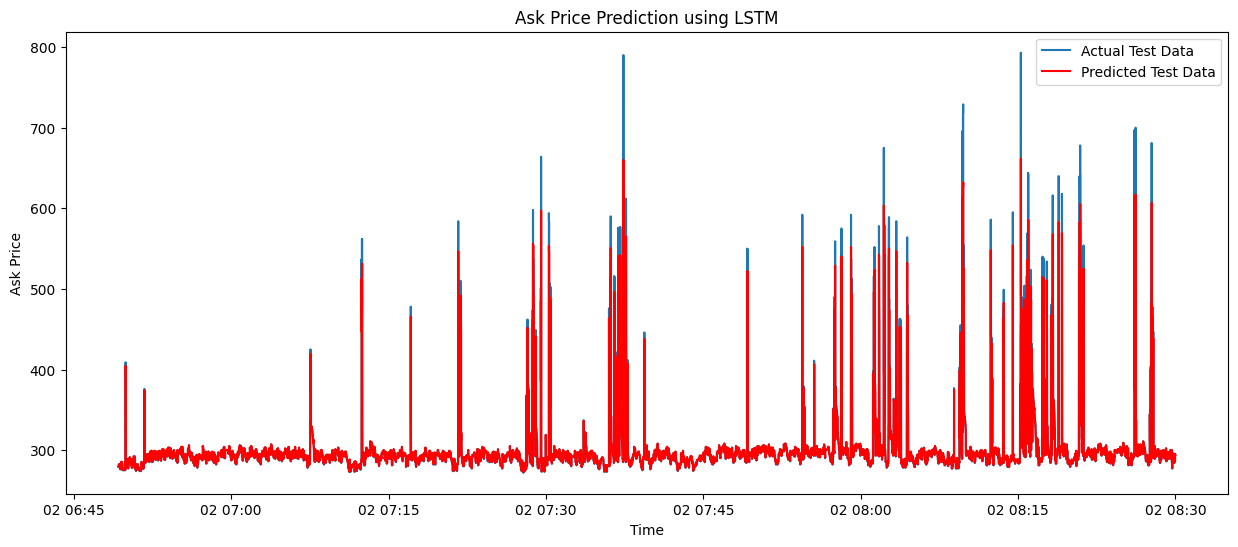

In [7]:
# Plotting
plt.figure(figsize=(15, 6))

# Use the timestamp range corresponding to the test data for x-axis
timestamps = data.index[train_size+look_back:train_size+look_back+len(testPredict)]

plt.plot(timestamps, testY_inv[0], label='Actual Test Data')
plt.plot(timestamps, testPredict.flatten(), label='Predicted Test Data', color='red')
plt.legend()
plt.title('Ask Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Ask Price')
plt.show()


